In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

https://www.kaggle.com/code/mattbast/image-classification-tensorflow-cnn/notebook

https://www.kaggle.com/datasets/datamunge/sign-language-mnist

https://www.kaggle.com/datasets/anirudhchauhan/sign-language-recognition-alphabets

In [ ]:
def num_to_letter(number):
    alphabet = ["A","B","C","D","E","F","G",'H',"I", "J", "K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y", "Z"]
    return alphabet[number]

In [ ]:
df = pd.read_csv('sign_mnist_train.csv')

In [ ]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB
None


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
img_height = 28
img_width = 28
BATCH_SIZE = 64
EPOCHS = 15

In [ ]:
train_data = df.head(25000)
val_data = df.tail(2455)

In [ ]:
train_labels = train_data.pop("label")
val_labels = val_data.pop("label")

In [ ]:
output_types = train_labels.unique()
print(output_types)
num_output = len(output_types)
print(num_output)

[ 3  6  2 13 16  8 22 18 10 20 17 19 21 23 24  1 12 11 15  4  0  5  7 14]
24


In [ ]:
train_labels.head(20)

0      3
1      6
2      2
3      2
4     13
5     16
6      8
7     22
8      3
9      3
10    18
11    10
12    16
13    22
14    20
15    16
16    17
17    13
18    13
19    19
Name: label, dtype: int64

In [ ]:
tf_train_data = tf.data.Dataset.from_tensor_slices((train_data.values, train_labels.values))
tf_val_data = tf.data.Dataset.from_tensor_slices((val_data.values, val_labels.values))

print(tf_train_data)
print(tf_val_data)

<TensorSliceDataset element_spec=(TensorSpec(shape=(784,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<TensorSliceDataset element_spec=(TensorSpec(shape=(784,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


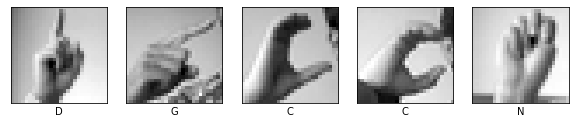

In [ ]:
plt.figure(figsize=(10,10))
i = 0

for image, label in tf_train_data.take(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(image.numpy().reshape((28, 28)), cmap='gray')
    plt.xlabel(num_to_letter(label.numpy()))

    i+=1

In [ ]:
def preprocess_image(image, label):
    image = tf.reshape(image, [28, 28, 1])
    image = tf.cast(image, tf.float32) / 255.
    
    return image, label

tf_train_data = tf_train_data.map(
    preprocess_image, 
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

tf_val_data = tf_val_data.map(
    preprocess_image, 
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

print(tf_train_data)
print(tf_val_data)

<ParallelMapDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<ParallelMapDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [ ]:
def pipeline(tf_data):
    tf_data = tf_data.shuffle(100)
    tf_data = tf_data.batch(BATCH_SIZE)
    tf_data = tf_data.prefetch(tf.data.experimental.AUTOTUNE)
    
    return tf_data

tf_train_data = pipeline(tf_train_data)
tf_val_data = pipeline(tf_val_data)

print(tf_train_data)
print(tf_val_data)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 1)),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),


    tf.keras.layers.Conv2D(36, (4, 4), activation='relu', dilation_rate = 2, input_shape=(img_height, img_width, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(36, (4, 4), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')
])

In [ ]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimiser, 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 28, 28, 1)         0         
                                                                 
 random_rotation_1 (RandomRo  (None, 28, 28, 1)        0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 28, 28, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 36)        612       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 36)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 36)         

In [ ]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),
]

In [ ]:
train_log = model.fit(
    tf_train_data,
    validation_data=tf_val_data,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/15
391/391 [==============================] - 18s 43ms/step - loss: 2.1776 - accuracy: 0.3221 - val_loss: 1.0933 - val_accuracy: 0.6631 - lr: 0.0010
Epoch 2/15
391/391 [==============================] - 16s 41ms/step - loss: 1.2128 - accuracy: 0.6048 - val_loss: 0.5925 - val_accuracy: 0.8090 - lr: 0.0010
Epoch 3/15
391/391 [==============================] - 17s 44ms/step - loss: 0.8025 - accuracy: 0.7341 - val_loss: 0.3314 - val_accuracy: 0.9014 - lr: 0.0010
Epoch 4/15
391/391 [==============================] - 16s 41ms/step - loss: 0.5636 - accuracy: 0.8116 - val_loss: 0.2901 - val_accuracy: 0.8961 - lr: 0.0010
Epoch 5/15
391/391 [==============================] - 16s 40ms/step - loss: 0.4228 - accuracy: 0.8619 - val_loss: 0.1919 - val_accuracy: 0.9430 - lr: 0.0010
Epoch 6/15
391/391 [==============================] - 16s 41ms/step - loss: 0.3387 - accuracy: 0.8864 - val_loss: 0.1923 - val_accuracy: 0.9279 - lr: 0.0010
Epoch 7/15
391/391 [==============================] - 16s 

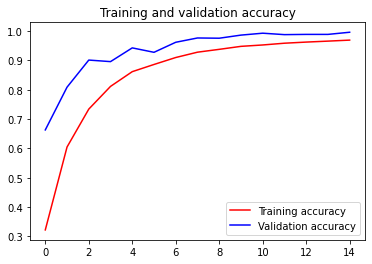

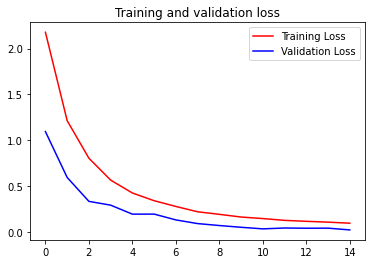

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = train_log.history['accuracy']
val_acc = train_log.history['val_accuracy']
loss = train_log.history['loss']
val_loss = train_log.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_df = pd.read_csv("sign_mnist_test.csv")

In [ ]:
test_label = test_df.pop('label')
test_X = test_df.values
test_X = test_X.reshape(-1, 28, 28, 1).astype("float32") / 255


In [ ]:
test_X.shape

(7172, 28, 28, 1)

In [ ]:
score = model.evaluate(test_X, test_label)

225/225 [==============================] - 2s 7ms/step - loss: 0.2051 - accuracy: 0.9398


In [ ]:
model.save('ASL.h5')
print('Model Saved!')
saved_model = load_model('ASL.h5')
print('Model Loaded!')
saved_model.summary()

Model Saved!
Model Loaded!
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 28, 28, 1)         0         
                                                                 
 random_rotation_1 (RandomRo  (None, 28, 28, 1)        0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 28, 28, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 36)        612       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 36)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)         

In [ ]:
model.save_weights('gfgModelWeights')
print('Model Saved!')
 
# load model
savedModel = model.load_weights('gfgModelWeights')
print('Model Loaded!')

Model Saved!
Model Loaded!


In [ ]:
# saving and loading the .h5 model
 
# save model
model.save_weights('gfgModelWeights.h5')
print('Model Saved!')
 
# load model
savedModel = model.load_weights('gfgModelWeights.h5')
print('Model Loaded!')

Model Saved!
Model Loaded!


In [ ]:
#TESTING SAVED MODEL

In [ ]:
pred_df = pd.read_csv("sign_mnist_test.csv")

need to use different way of drawing graph bc plt.show doesnt work in while loop.

Test your sign langauge knowledge by going against a computer!
enter 'start' to play game and 'stop' to end game
start
Your guess: a
Computer guess:  G
Actual letter was:  G
Computer won
Your guess: a
Computer guess:  T
Actual letter was:  T
Computer won
Your guess: a
Computer guess:  Y
Actual letter was:  Y
Computer won
Your guess: a
Computer guess:  F
Actual letter was:  F
Computer won
Your guess: a
Computer guess:  A
Actual letter was:  A
Computer won
Your guess: a
Computer guess:  C
Actual letter was:  O
U both lost!
Your guess: a
Computer guess:  A
Actual letter was:  A
Computer won
Your guess: a
Computer guess:  X
Actual letter was:  X
Computer won
Your guess: a
Computer guess:  V
Actual letter was:  V
Computer won
Your guess: a
Computer guess:  E
Actual letter was:  E
Computer won
Your guess: a
Computer guess:  B
Actual letter was:  B
Computer won
Your guess: a
Computer guess:  V
Actual letter was:  V
Computer won
Your guess: a
Computer guess:  M
Actual letter was:  E
U both los

KeyboardInterrupt: ignored

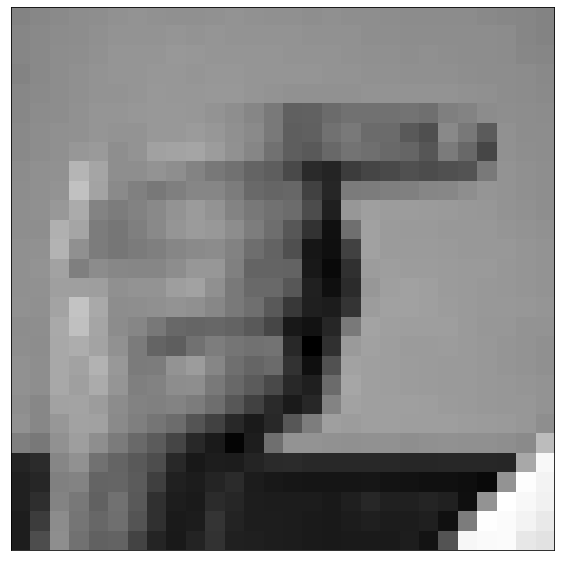

In [ ]:
#play game

plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.grid(False)

print("Test your sign langauge knowledge by going against a computer!")

print("enter 'start' to play game and 'stop' to end game")

if input() == 'start':
  status = True
  while(status != False):

    pd_prediction = pred_df.sample()
    prediction_label = pd_prediction.pop('label')
    my_prediction = pd_prediction.values
    my_prediction = my_prediction.reshape(-1, 28, 28, 1).astype("float32") / 255.

    predictions = model.predict(my_prediction)
    score = tf.nn.softmax(predictions)
    computer_guess = num_to_letter(np.argmax(score))

    prediction_num = int(prediction_label.values)

    answer = num_to_letter(prediction_num)


    plt.imshow(my_prediction.reshape((28, 28)), cmap='gray')

    player_guess = input("Your guess: ")
    print('Computer guess: ', computer_guess)

    print('Actual letter was: ', answer)

    if player_guess == answer and computer_guess == answer:
      print("U both won!")
    elif player_guess == answer:
      print("You won")
    elif computer_guess == answer:
      print("Computer won")
    else:
      print("U both lost!")

    if player_guess == 'stop':
      status = False


In [ ]:
df